# Look at SO Data

- compare passes from SO and PSP and make plots to compare (include labels)
    - look at polarity crossing from each
    - minimum variance analyis
    - add L1 data from WIND

- animation showing time evolution of magnetograms with PSP data for last week august through first week september

In [1]:
import astropy
import sunpy, sunpy.map
import pfsspy
import matplotlib.pyplot as plt
import numpy as np

import sys, os

sys.path.append(os.path.realpath(''))
import utilities as utils
import psp_funcs as psp_funcs
import pfss_funcs as pfss_funcs
import pandas as pd
import astrospice

In [2]:
rss_values = np.arange(2.0, 3.75, 0.25)
IMG_DIR = os.path.realpath('../mag_model/images')
SO_DATA_DIR = os.path.realpath('../mag_model/data/so')
PSP_DATA_DIR = os.path.realpath('../mag_model/data/psp')
HCS_DATA_DIR = os.path.realpath('../mag_model/data/gong')

In [3]:
so_mag_file = os.path.join(SO_DATA_DIR, 'B_SO_RTN.csv')
so_data = pd.read_csv(so_mag_file, names=['datetime', 'Br', 'Bt', 'Bn'], engine='python')
# split the datetime column into a separate date and time column
so_data[['date', 'time']] = so_data.datetime.str.split('/', expand=True)
dates = so_data.date + 'T' + so_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
so_data['jd'] = jd_dates
so_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
so_data['polarity'] = np.sign(so_data.Br)

# remove the data from september 5 due to the solar flare -- set up a flag column
date_str, date_obj, date_jd = utils.get_dates('2022-09-05T00:00:00.000')
flag_inds = np.logical_and(so_data.date >= date_jd - 0.2, so_data.date <= date_jd + 1)
flag = np.array(['' for x in range(len(so_data.datetime))])
flag[flag_inds] = 'flare'
so_data['flag'] = flag

In [4]:
# get predicted solar orbiter position
import astrospice

kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
so_coords_inertial = astrospice.generate_coords('SOLAR ORBITER', so_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
so_coords_carr = so_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [7]:
coords = pd.DataFrame()
for rss in rss_values:
    # get psp at source surface
    so_at_source_surface = psp_funcs.coord_projection(so_coords_carr, rss, so_data.date_obj)

    # save these values with corresponding source surface height as column name to the data array
    coords['lon_' + str(int(rss*100))] = so_at_source_surface.lon.degree
    coords['lat_' + str(int(rss*100))] = so_at_source_surface.lat.degree

In [16]:
# get correct polarity data to plot for SO (bin since so man measurements)
so_ss = so_at_source_surface[::8]
so_Br = [np.median(so_data.Br[i:i+8]) for i in range(0, len(so_data.Br), 8)]
so_pol = np.sign(so_Br)

In [9]:
filenames = ['adapt41311_03k012_202209170000_i00005600n1.fts.gz', 
'adapt41311_03k012_202209180000_i00005700n1.fts.gz', 'adapt40311_03k012_202209190000_i00005600n1.fts.gz', 
'adapt41311_03k012_202209200000_i00005600n1.fts.gz', 'adapt41311_03k012_202209210000_i00005600n1.fts.gz']	

# create dataframe
hcs_data = []

In [10]:
for filename in filenames:

    # download magnetogram
    remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
    local_path = "data/gong"
    if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
        print(f"Downloading {local_path}/{filename}") 
        os.system(f'wget {remote_path}/{filename} -P {local_path}')
    else : print(f"{local_path}/{filename} already exists!" )

    # get an adapt magnetogram
    filepath = f"{local_path}/{filename}"
    adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

    # run pfss model for varying RSS values
    for rss in rss_values:
        # run the PFSS model with rss 
        pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

        # magnetic field line tracing starting from photosphere
        flines = pfss_funcs.pfss2flines(pfss_model)

        # get Br at the source surface from the pfss model
        pfss_br = pfss_model.source_surface_br

        # get HCS
        hcs = [pfss_model.source_surface_pils[0].lon, pfss_model.source_surface_pils[0].lat]

        # add this to dataframe
        df_name = str(int(rss*100)) + "_" + str(pfss_br.date)
        hcs_df = pd.DataFrame({str(df_name) : hcs})
        hcs_data.append(hcs_df)

# concatenate dataframes
hcs_csv = pd.concat(hcs_data, axis=1)

data/gong/adapt41311_03k012_202209170000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209180000_i00005700n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209190000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209200000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209210000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


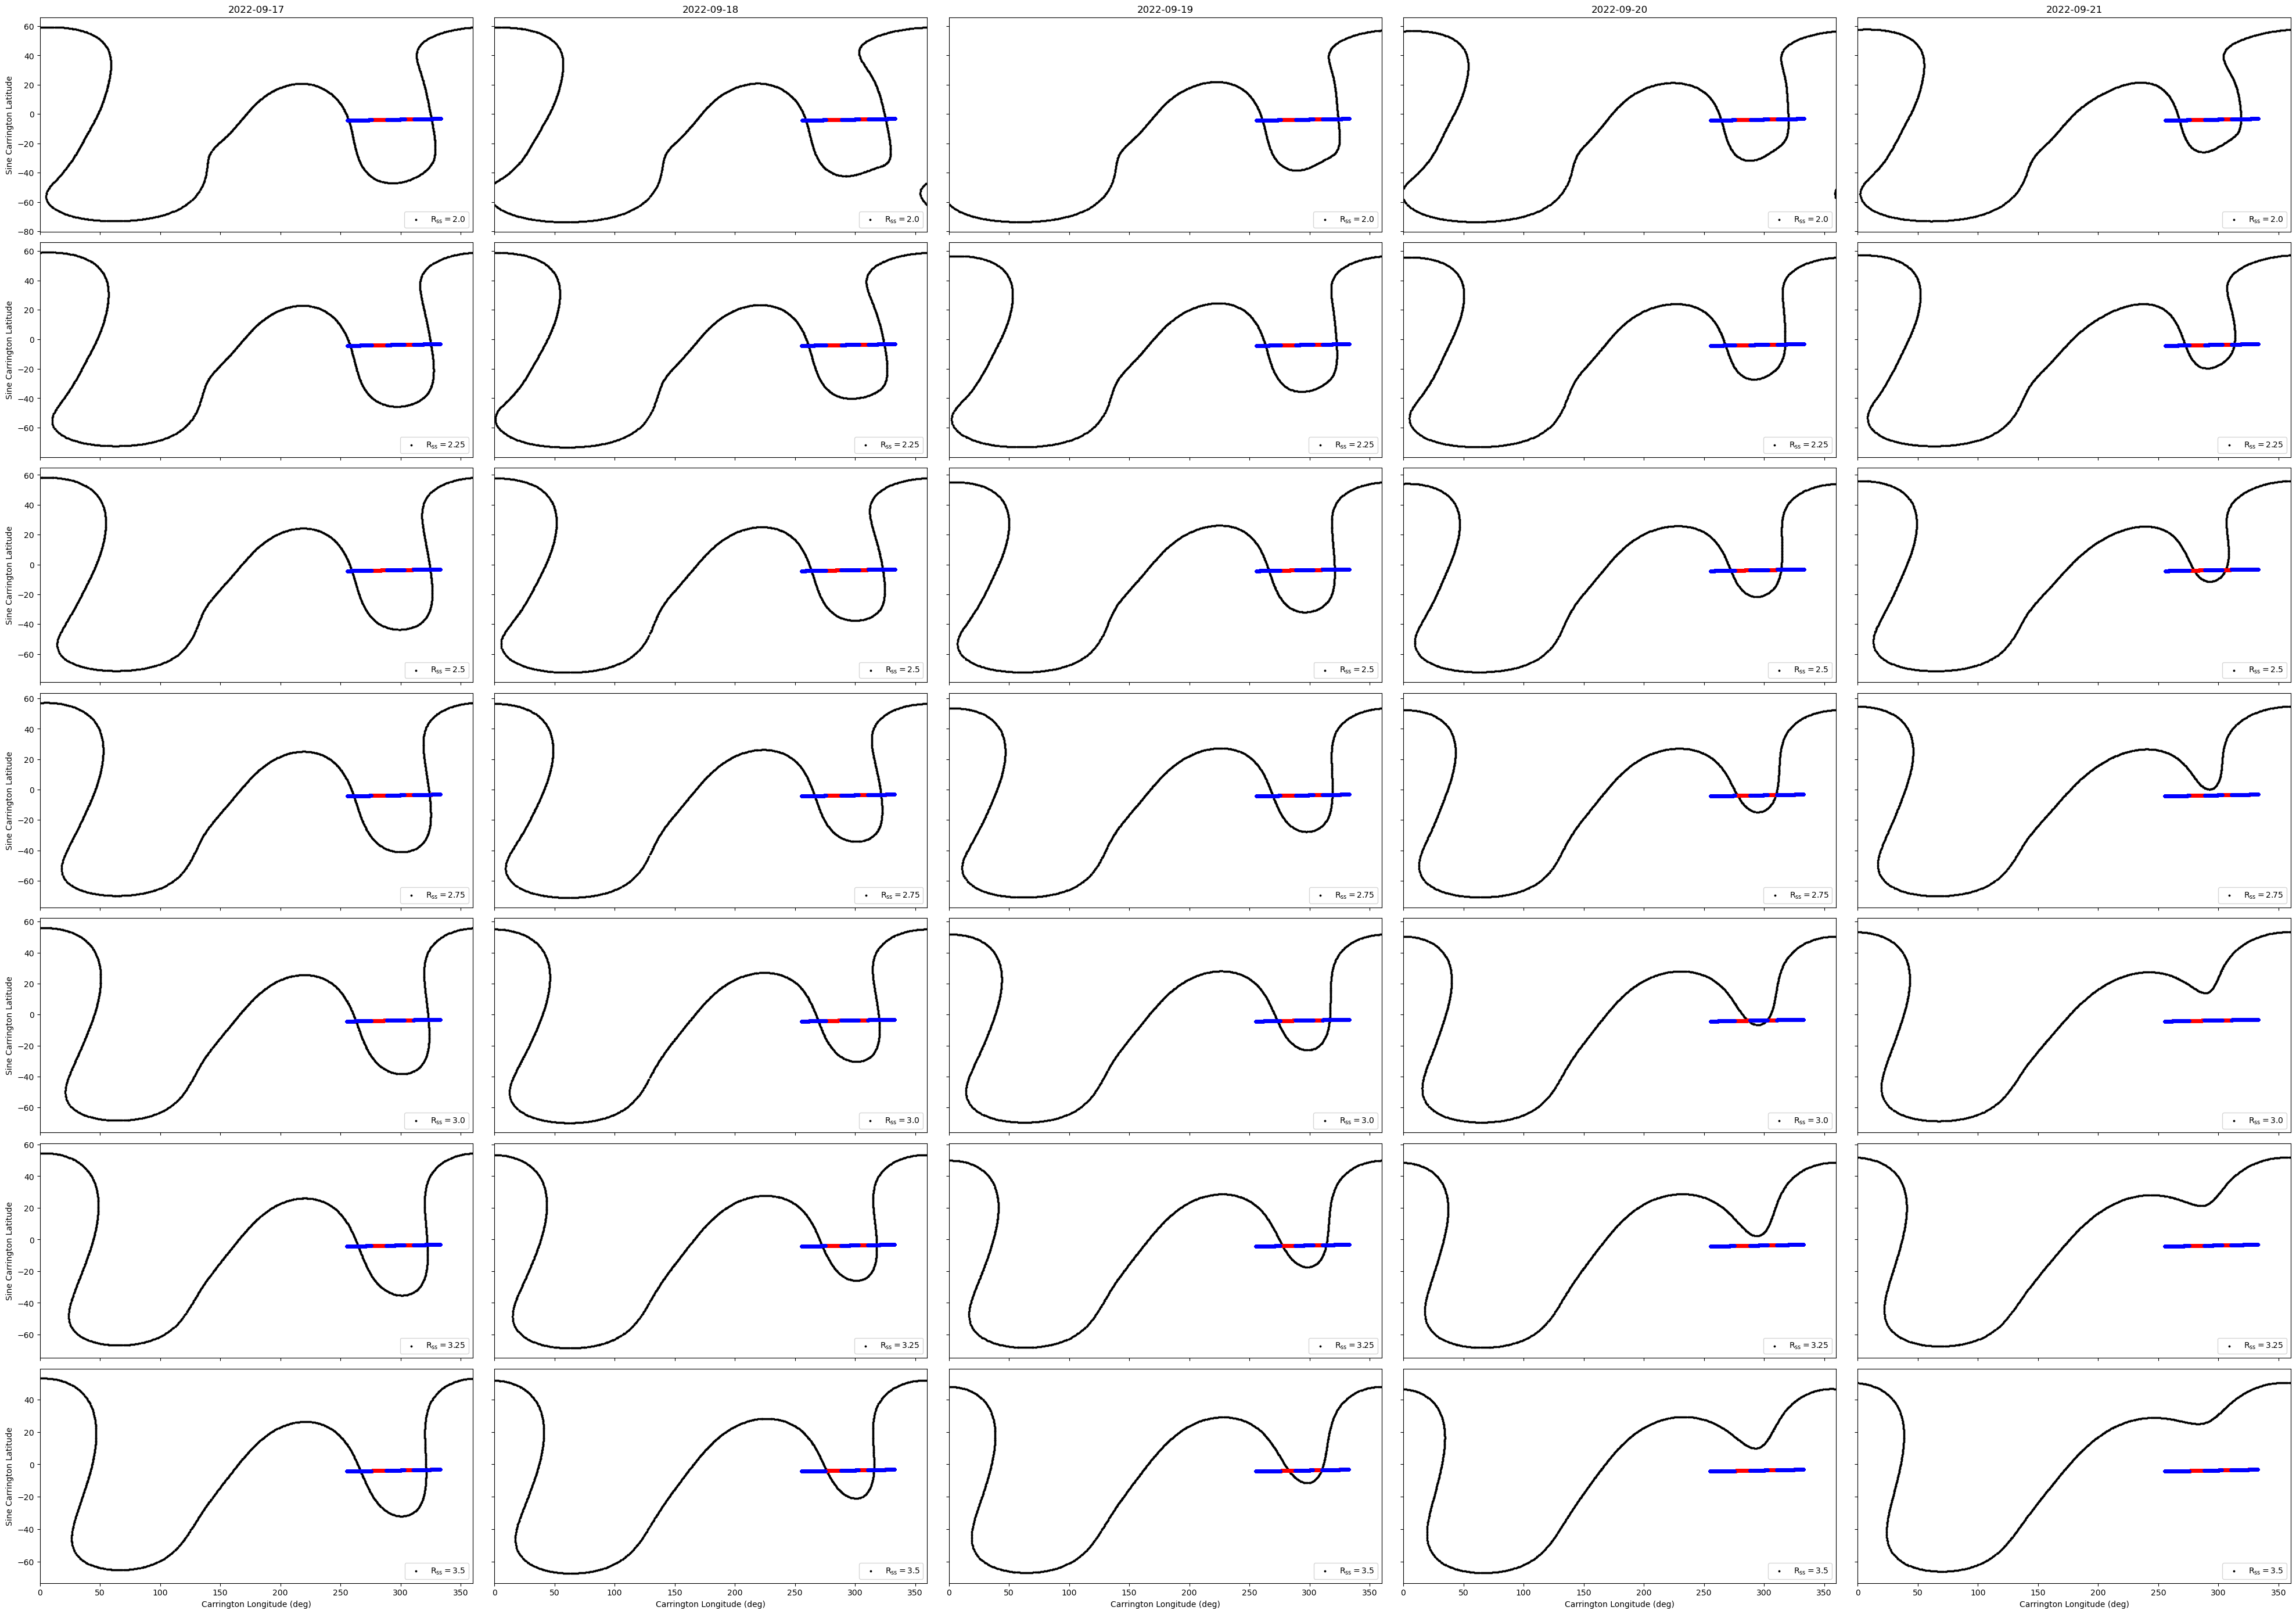

In [20]:
# comparison plotting
# set up plotting grid
import numpy as np
fig, axs = plt.subplots(7, 5, sharey='row', sharex='col', figsize=[50, 35], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

for i, h in enumerate(hcs_data):
    head = h.columns[0]
    # for i, h in enumerate(hcs.columns):
    # determine the source surface radius and date
    rss, d = float(head.split('_')[0]), head.split('_')[1]
    lc = str(int(rss))

    # get indices for axs
    j = int((rss/100*4) - 8)
    k = int(i/7)

    # plot the HCS
    # hs = hcs.iloc[:, i]
    axs[j, k].scatter(list(h.iloc[0, :]), list(h.iloc[1, :]), color='black', s=3, label= r'$\rm R_{ss} = $' + str(float(rss/100)))

    # plot the PSP trajectory on top of it
    pos = np.where(so_data.polarity == 1)[0]
    neg = np.where(so_data.polarity == -1)[0]
    # pos = np.where(so_pol == 1)[0]
    # neg = np.where(so_pol == -1)[0]

    axs[j, k].scatter(coords.loc[:, 'lon_' + lc][pos], coords.loc[:, 'lat_' + lc][pos], color='red', s=10)
    axs[j, k].scatter(coords.loc[:, 'lon_' + lc][neg], coords.loc[:, 'lat_' + lc][neg], color='blue', s=10)

    # set y-label
    if k == 0:
        axs[j, k].set_ylabel("Sine Carrington Latitude")
    
    # set x label
    if j == 6:
        axs[j, k].set_xlabel("Carrington Longitude (deg)")

    # set title (date)
    if j == 0:
        axs[j, k].set_title(d.split('T')[0])

    # set x limit
    axs[j, k].set_xlim(0,360)
    axs[j, k].legend(loc='lower right')

# fig_title = str(pfss_br.date) + '_' + str(rss) + '.png'
fig_title = 'so_rss_date_comparison.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')
    

# Creating comparison plot between PSP and SO trajectories

- choose good magnetogram: 9/21
- choose good Rss height: 2.5 
- do PFSS and find HCS crossing for this magnetogram
- plot PSP and SO trajectories on the magnetogram

In [21]:
rss = 2.5

In [48]:
# read in PSP data
psp_txt_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/psp/BrAU2_mode.csv'
psp_data = pd.read_csv(psp_txt_file, names=['datetime', 'Br'], engine='python')

# split the datetime column into a separate date and time column
psp_data[['date', 'time']] = psp_data.datetime.str.split('/', expand=True)
dates = psp_data.date + 'T' + psp_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
psp_data['jd'] = jd_dates
psp_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
psp_data['polarity'] = np.sign(psp_data.Br)

# flag the time of the flare
date_str, date_obj, date_jd = utils.get_dates('2022-09-05T00:00:00.000')
flag_inds = np.logical_and(psp_data.date >= date_jd - 0.2, psp_data.date <= date_jd + 1)
flag = np.array(['' for x in range(len(psp_data.datetime))])
flag[flag_inds] = 'flare'
psp_data['flag'] = flag

# get position via astrospice
kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', psp_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get coordinates at source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [49]:
# read in so data
so_mag_file = os.path.join(SO_DATA_DIR, 'B_SO_RTN.csv')
so_data = pd.read_csv(so_mag_file, names=['datetime', 'Br', 'Bt', 'Bn'], engine='python')

# split the datetime column into a separate date and time column
so_data[['date', 'time']] = so_data.datetime.str.split('/', expand=True)
dates = so_data.date + 'T' + so_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
so_data['jd'] = jd_dates
so_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
so_data['polarity'] = np.sign(so_data.Br)

# get the predicted path of SO
kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
so_coords_inertial = astrospice.generate_coords('SOLAR ORBITER', so_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
so_coords_carr = so_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get coordinates at source surface
so_at_source_surface = psp_funcs.coord_projection(so_coords_carr, rss, so_data.date_obj)

/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [46]:
# create PFSS model
rss = 2.5
filename = 'adapt41311_03k012_202209210000_i00005600n1.fts.gz'
# filename = 'adapt41311_03k012_202209220000_i00025600n1.fts.gz'
remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
local_path = "data/gong"
if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
    print(f"Downloading {local_path}/{filename}") 
    os.system(f'wget {remote_path}/{filename} -P {local_path}')
else : print(f"{local_path}/{filename} already exists!" )

# get an adapt magnetogram
filepath = f"{local_path}/{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

# run the PFSS model with rss 
pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

# magnetic field line tracing starting from photosphere
flines = pfss_funcs.pfss2flines(pfss_model)

data/gong/adapt41311_03k012_202209210000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


In [47]:
# get SO data for plotting -- bin in two hour chunks (every 16 measurements)
so_ss = so_at_source_surface[::16]
so_Br = [np.median(so_data.Br[i:i+16]) for i in range(0, len(so_data.Br), 16)]
so_pol = np.sign(so_Br)

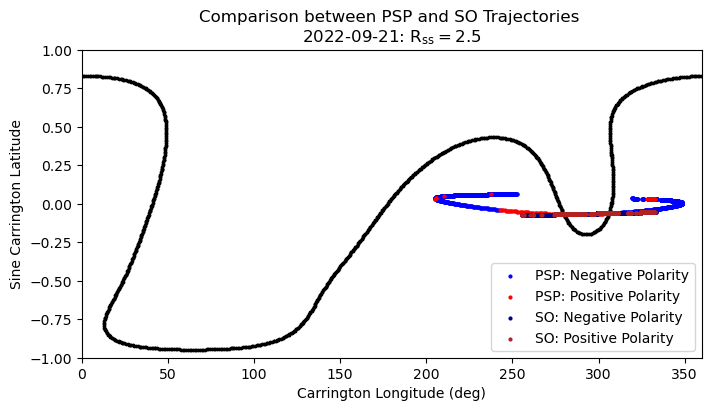

In [52]:
import astropy.units as u

# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# create the figure
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

# plot the HCS
ax.scatter(hcs.lon, np.sin(hcs.lat), color='black', s=3)

# plot the PSP trajectory on top of it
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

ax.scatter(psp_at_source_surface.lon[neg], np.sin(psp_at_source_surface.lat[neg]), color='blue', s=4,
label='PSP: Negative Polarity')
ax.scatter(psp_at_source_surface.lon[pos], np.sin(psp_at_source_surface.lat[pos]), color='red', s=4, 
label='PSP: Positive Polarity')

# plot the SO trajectory on top of it
pos = np.where(so_pol == 1)
neg = np.where(so_pol == -1)

ax.scatter(so_ss.lon[neg], np.sin(so_ss.lat[neg]), color='navy', s=4,
label='SO: Negative Polarity')
ax.scatter(so_ss.lon[pos], np.sin(so_ss.lat[pos]), color='firebrick', s=4, 
label='SO: Positive Polarity') 

ax.set_title("Comparison between PSP and SO Trajectories \n" + str(pfss_br.date)[:-13] + r": $\rm R_{ss} =$" + str(rss))
ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(0,360)
ax.set_ylim(-1, 1)
ax.legend(loc='lower right')

fig_title = 'so_psp_921_25.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')

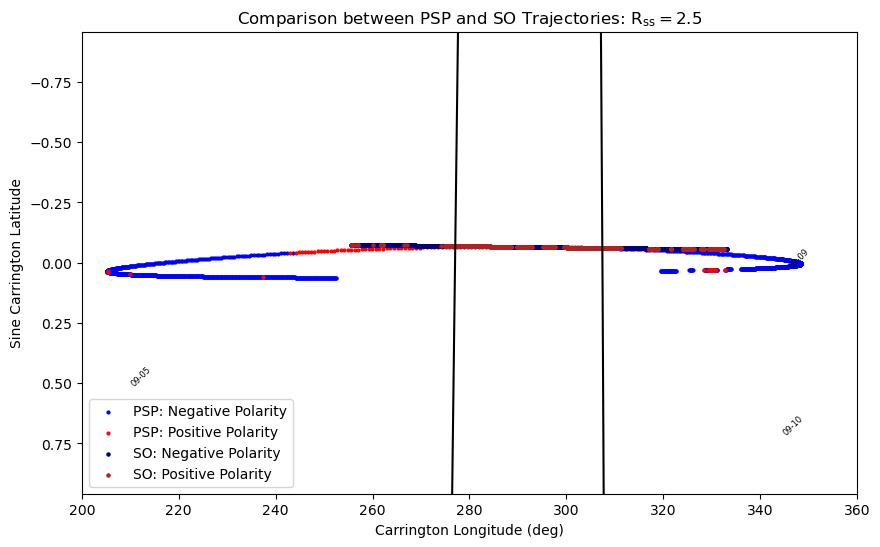

In [56]:
# zoomed in  plot
import astropy.units as u

# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# create the figure
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()

# plot the HCS
ax.plot(hcs.lon, hcs.lat, color='black')

# plot the PSP trajectory on top of it
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

ax.scatter(psp_at_source_surface.lon[neg], np.sin(psp_at_source_surface.lat[neg]), color='blue', s=4,
label='PSP: Negative Polarity')
ax.scatter(psp_at_source_surface.lon[pos], np.sin(psp_at_source_surface.lat[pos]), color='red', s=4, 
label='PSP: Positive Polarity')

# plot the SO trajectory on top of it
pos = np.where(so_pol == 1)
neg = np.where(so_pol == -1)

ax.scatter(so_ss.lon[neg], np.sin(so_ss.lat[neg]), color='navy', s=5,
label='SO: Negative Polarity')
ax.scatter(so_ss.lon[pos], np.sin(so_ss.lat[pos]), color='firebrick', s=5, 
label='SO: Positive Polarity') 

# add labels to points on the plot of the trajectories
psp_inds = [np.where(psp_data.date == d)[0][0] for d in np.unique(psp_data.date)]
so_inds = [np.where(so_data.date == d)[0][0] for d in np.unique(so_data.date)]

for i, x in enumerate(list(zip(psp_at_source_surface.lon[psp_inds], psp_at_source_surface.lat[psp_inds]))):
    label = np.unique(psp_data.date)[i]
    ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, 1), ha='center', fontsize='6', rotation=45)

for i, x in enumerate(list(zip(so_at_source_surface.lon[so_inds], so_at_source_surface.lat[so_inds]))):
    label = np.unique(so_data.date)[i]
    ax.annotate(label[-5:], (x[0].value, x[1].value), ha='center', textcoords="offset points", xytext=(0, -2), fontsize='6', rotation=45)

ax.set_title("Comparison between PSP and SO Trajectories" + r": $\rm R_{ss} =$" + str(rss))
ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(200, 360)
ax.set_ylim(np.sin(-5), np.sin(5))
ax.legend(loc='lower left')

fig_title = 'so_psp_921_25_zoom.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')

In [ ]:
pos = np.where(so_data.polarity == 1)[0]
neg = np.where(so_data.polarity == -1)[0]
so_at_source_surface.lon[pos], so_at_source_surface.lon[neg]

np.where(so_at_source_surface.lat[pos] == so_at_source_surface.lat[neg])

In [ ]:
# pull data from the text files for position
so_mag_file = os.path.join(SO_DATA_DIR, 'spp_fld_ephem_solo_hg_position_rs_phi.txt')
lat_data = pd.read_csv(so_mag_file, sep='         ', names=['datetime', 'lat'], engine='python')
so_mag_file = os.path.join(SO_DATA_DIR, 'spp_fld_ephem_solo_hg_position_rs_th.txt')
lon_data = pd.read_csv(so_mag_file, sep='        ', names=['datetime', 'lon'], engine='python')
a, b = np.where(lat_data.datetime == '2022-09-04/00:00:00.000')[0][0], np.where(lat_data.datetime == '2022-09-09/18:00:00.000')[0][0]
# use_lon = np.logical_or(lon_data.datetime == '2022-09-03/00:00:00.000', lon_data.datetime == '2022-09-10/00:00:00.000')
# a, b = np.where(lat_data.datetime == )

In [ ]:
plt.plot(lat_data.lat[a:b], lon_data.lon[a:b], color='thistle', label='from text file')
plt.plot(so_ss.lon, so_ss.lat, color='coral', label = 'from astrospice')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

In [ ]:
fig, ax = plt.subplots(2)
ax[0].scatter(so_ss.lon[pos], so_ss.lat[pos], color='firebrick', s=1, 
label='SO: Positive Polarity')
ax[0].scatter(so_ss.lon[neg], so_ss.lat[neg], color='navy', s=1,
label='SO: Negative Polarity')

ax[1].scatter(so_ss.lon[neg], so_ss.lat[neg], color='navy', s=1,
label='SO: Negative Polarity')
ax[1].scatter(so_ss.lon[pos], so_ss.lat[pos], color='firebrick', s=1, 
label='SO: Positive Polarity')

len(so_ss), len(so_at_source_surface), len(psp_data.date)

# Create Animation: Animating PSP moving along with changing HCS
- pull multiple magnetogram files in order to calculate the new HCS (done previously)
- have constant plot of the PSP trajector
- at each changing time point, plot a larger dot of where PSP is at the moment
- should loop through the PSP dates/positions 
- get a new magnetogram for each individual date

In [ ]:
np.unique(psp_data.date)

In [64]:
# radial source surface value
rss = 2.5
br, hcs_data, mag = [], [], []

# list of magnetograms
filenames = ['adapt40311_03k012_202208300000_i00005600n1.fts.gz', 'adapt40311_03k012_202208310000_i00045600n1.fts.gz', 
'adapt40311_03k012_202209010000_i00005500n1.fts.gz', 'adapt40311_03k012_202209020000_i00005600n1.fts.gz', 'adapt40311_03k012_202209030000_i00045600n1.fts.gz', 
'adapt40311_03k012_202209040000_i00045600n1.fts.gz', 'adapt40311_03k012_202209050000_i00005600n1.fts.gz', 'adapt40311_03k012_202209060000_i00005600n1.fts.gz',
'adapt40311_03k012_202209070000_i00005600n1.fts.gz', 'adapt40311_03k012_202209080000_i00000500n1.fts.gz', 'adapt40311_03k012_202209090000_i00050600n1.fts.gz',
'adapt40311_03k012_202209100000_i00005700n1.fts.gz', 'adapt41311_03k012_202209110000_i00025600n1.fts.gz', 'adapt41311_03k012_202209120000_i00045500n1.fts.gz', 
'adapt41311_03k012_202209130000_i00025600n1.fts.gz']

# calculate HCS for each magnetogram
for filename in filenames:

    # download magnetogram
    remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
    local_path = "data/gong"
    if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
        print(f"Downloading {local_path}/{filename}") 
        os.system(f'wget {remote_path}/{filename} -P {local_path}')
    else : print(f"{local_path}/{filename} already exists!" )

    # get an adapt magnetogram
    filepath = f"{local_path}/{filename}"
    adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)
    mag.append(adapt_magnetogram)

    # run the PFSS model with rss 
    pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

    # magnetic field line tracing starting from photosphere
    flines = pfss_funcs.pfss2flines(pfss_model)

    # get Br at the source surface from the pfss model
    pfss_br = pfss_model.source_surface_br
    br.append(pfss_br)

    # get HCS
    hcs = [pfss_model.source_surface_pils[0].lon, pfss_model.source_surface_pils[0].lat]

    # add this to dataframe
    df_name = str(int(rss*100)) + "_" + str(pfss_br.date)
    hcs_df = pd.DataFrame({str(df_name) : hcs})
    hcs_data.append(hcs_df)


data/gong/adapt40311_03k012_202208300000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202208310000_i00045600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209010000_i00005500n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209020000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209030000_i00045600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209040000_i00045600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209050000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209060000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209070000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209080000_i00000500n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209090000_i00050600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt40311_03k012_202209100000_i00005700n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209110000_i00025600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209120000_i00045500n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


data/gong/adapt41311_03k012_202209130000_i00025600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


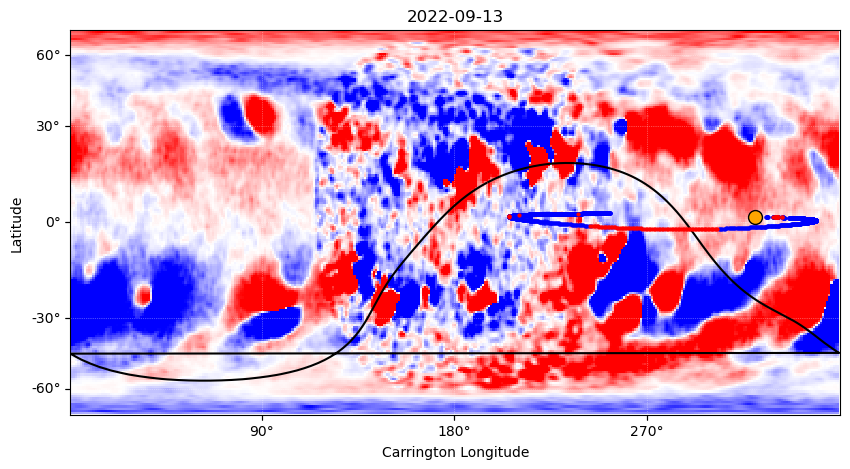

In [72]:
from matplotlib import animation
import matplotlib.gridspec as gridspec
from IPython import display
import matplotlib.colors as colors

hcs_use = hcs_data
br_use = br[:-3]
br_use = mag

psp_ss = psp_at_source_surface[::4]
Br = [np.median(psp_data.Br[i:i+4]) for i in range(0, len(psp_data.Br), 4)]
pol = np.sign(Br)
da = [psp_data.date[i] for i in range(0, len(psp_data.date), 4)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=br_use[0])

ax.set_xlim(0, 360)
# ax.set_ylim(-80, 80)
ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Carrington Latitude")

# set up the pieces of the animation
hcs, = ax.plot([], [], color='black', zorder=2)
psp_loc, = ax.plot([], [], marker='o', markersize=10, color='orange', markeredgecolor='k', linewidth=0.5, zorder=4)
# br_arr = ax.imshow(br[0].data, zorder=1)
# br[0].plot_settings['norm'] = colors.LogNorm()
br_arr = br_use[0].plot(axes=ax, cmap='bwr', vmin=-10, vmax=10)
# plt.colorbar(br_arr, cax=ax)
# br_arr = mag[0].plot(axes=ax)

# set up the psp trajectory portion of the plot
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)
psp_neg = ax.scatter(psp_at_source_surface.lon[neg], psp_at_source_surface.lat[neg].value + 90, color='blue', s=4, zorder=3)
psp_pos = ax.scatter(psp_at_source_surface.lon[pos], psp_at_source_surface.lat[pos].value + 90, color='red', s=4, zorder=3)


def animate(i):

    # get the date
    d = da[i]

    # find the correct magnetogram (relate it to the index in the list of unique dates)
    ind = np.where(d == np.unique(psp_data.date))[0][0]
    # mag_file = filenames[ind]
    
    #### include background PFSS field (from individual magnetogram, changes)
    # get Br at the source surface from the pfss model
    pfss_br = br_use[ind] 
    # plot source surface Br
    # pfss_br.plot_settings['norm'] = colors.LogNorm(100, pfss_br.max())
    br_arr.set_array(pfss_br.data)
    # plt.colorbar(br_arr, cax=ax)

    #### plot HCS (changes each time)
    # get HCS
    h = hcs_use[ind]
    # # plot the HCS
    y = [i.value + 90 for i in list(h.iloc[1, :])]
    hcs.set_data([list(h.iloc[0, :])], y)

    # #### plot the moving location of PSP on top of this (changes each time)
    # # if psp_data.polarity[i] == 1:
    # #     c = 'blue'
    # # else:
    # #     c = 'red'
    psp_loc.set_data([psp_ss.lon[i].value], [psp_ss.lat[i].value + 90])

    # set title
    ax.set_title(str(d))

    # return animation objects
    return br_arr, psp_neg, psp_pos, psp_loc, 

anim = animation.FuncAnimation(fig, animate, init_func=None, frames=int(len(psp_data.date)/4), interval=10, repeat=False, blit=True)

writervideo = animation.FFMpegWriter(fps=30)
anim.save('psp_br_mag_anim.gif', writer=writervideo)
plt.show()

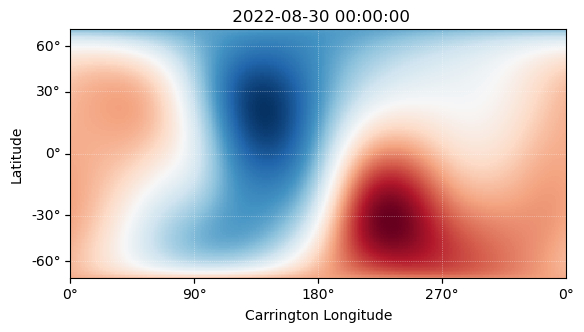

In [62]:
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(projection=br_use[0])
# br_use[0].plot(axes=ax, cmap='bwr')
br_use[0].plot()

# Create map of magnetic field for comparison
- get Br from pfss model (9/21, rss=2.5)
- get Br data from psp text file
- get Br data from other instrument


In [19]:
# generate pfss model for 9/21 with rss = 2.5
# import pyspedas
rss = 2.5
filename = 'adapt41311_03k012_202209210000_i00005600n1.fts.gz'
# filename = 'adapt41311_03k012_202209220000_i00025600n1.fts.gz'
remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
local_path = "data/gong"
if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
    print(f"Downloading {local_path}/{filename}") 
    os.system(f'wget {remote_path}/{filename} -P {local_path}')
else : print(f"{local_path}/{filename} already exists!" )

# get an adapt magnetogram
filepath = f"{local_path}/{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

# run the PFSS model with rss 
pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

# magnetic field line tracing starting from photosphere
flines = pfss_funcs.pfss2flines(pfss_model)

data/gong/adapt41311_03k012_202209210000_i00005600n1.fts.gz already exists!
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


In [20]:
# read in PSP data
psp_txt_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/psp/BrAU2_mode.csv'
psp_data = pd.read_csv(psp_txt_file, names=['datetime', 'Br'], engine='python')

# split the datetime column into a separate date and time column
psp_data[['date', 'time']] = psp_data.datetime.str.split('/', expand=True)
dates = psp_data.date + 'T' + psp_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
psp_data['jd'] = jd_dates
psp_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
psp_data['polarity'] = np.sign(psp_data.Br)

# flag the time of the flare
date_str, date_obj, date_jd = utils.get_dates('2022-09-05T00:00:00.000')
flag_inds = np.logical_and(psp_data.date >= date_jd - 0.2, psp_data.date <= date_jd + 1)
flag = np.array(['' for x in range(len(psp_data.datetime))])
flag[flag_inds] = 'flare'
psp_data['flag'] = flag

# get position via astrospice
kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', psp_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get coordinates at source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

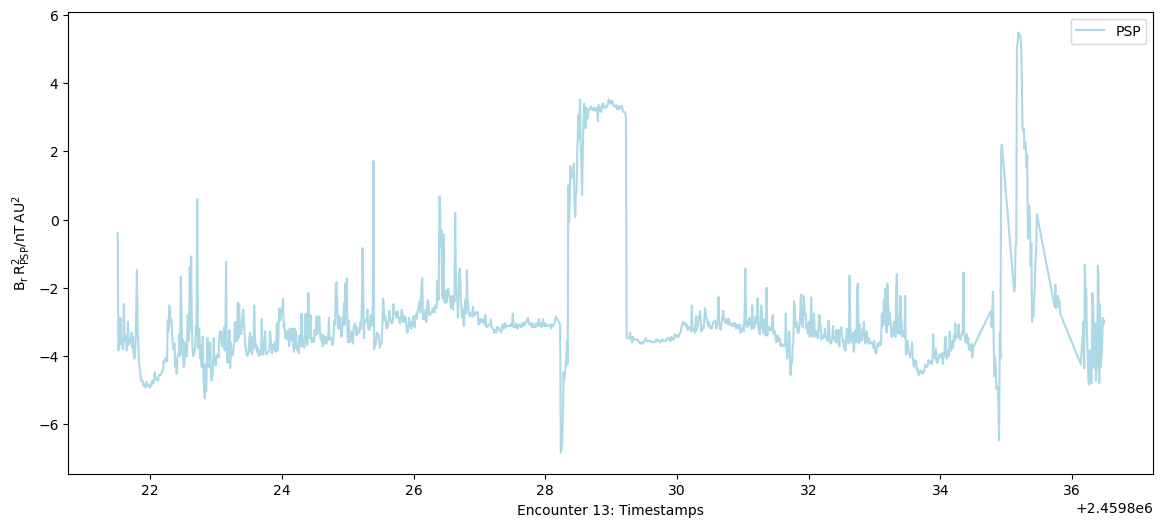

In [29]:
timestamps = jd_dates # - jd_dates[0]
psp_br = sunpy.map.sample_at_coords(pfss_model.source_surface_br, psp_at_source_surface)

psp_br_plot = psp_data.Br/1e-9 * (2.5/215)**2
pfss_br_plot = psp_br/1e-9 * (2.5/215)**2
plt.figure(figsize=[14, 6])
# plt.plot(timestamps, psp_br, color='purple', label='PFSS')
plt.plot(timestamps, psp_data.Br, color='lightblue', label='PSP')
plt.xlabel('Encounter 13: Timestamps')
plt.ylabel(r'$\rm B_r\,R^2_{PSP}/nT\,AU^2$')
plt.legend()